In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [39]:
hidden_size= 128
num_classes= 10
num_epochs= 3
batch_size= 100
learning_rate= .001
input_size= 28
sequence_length= 28
num_layers= 2

In [3]:
train_dataset= torchvision.datasets.FashionMNIST(root='', train= True, transform= transforms.ToTensor())

In [4]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train

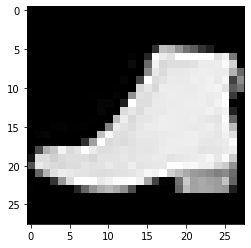

In [6]:
import matplotlib.pyplot as plt
z, _ = train_dataset[7000]
plt.imshow(z.numpy()[0], cmap='gray')
plt.show()

In [7]:
train_loader= torch.utils.data.DataLoader(dataset= train_dataset, batch_size= batch_size, shuffle= True )

In [8]:
test_dataset= torchvision.datasets.FashionMNIST(root='', train= False, transform= transforms.ToTensor())
test_loader= torch.utils.data.DataLoader(dataset= test_dataset, shuffle= False)

In [9]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [40]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers= num_layers
        self.hidden_size= hidden_size
        self.rnn= nn.RNN(input_size, hidden_size, num_layers, batch_first= True)
        #input should be in the shape: [batch size, seq, input size]
        self.fc= nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        #initial hidden shape
        h0= torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        #output shape= [batch_size, seq_size, hidden_size]
        #out (N, 28, 128)
        #we have to reshape it before giving to fc layer
        out= out[:, -1, :]
        #out(N, 128)
        out= self.fc(out)
        return out

        
model= RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [41]:
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)


In [42]:
n_total_steps= len(train_loader)
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
        images= images.reshape(-1, sequence_length, input_size).to(device)
        labels= labels.to(device)
        
        #forward pass
        outputs= model(images)
        loss= criterion(outputs, labels)
        
        #backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i / 100 == 0:
            print(f'epochs:[{epoch+1}/{num_epochs}],step:[{i+1}/{n_total_steps}],loss:{loss.item():.4f}')

epochs:[1/3],step:[1/600],loss:2.2913
epochs:[2/3],step:[1/600],loss:0.7588
epochs:[3/3],step:[1/600],loss:0.7475


In [43]:
#TEST THE MODEL
with torch.no_grad():
    n_correct= 0
    n_samples= 0
    for images, labels in test_loader:
        images= images.reshape(-1,sequence_length, input_size).to(device)
        labels= labels.to(device)
        outputs= model(images)
        
        #max return value
        _, predicted= torch.max(outputs.data, 1)
        n_samples+= labels.size(0)
        n_correct+= (predicted==labels).sum().item()
    acc= 100*n_correct/n_samples
    print(f'accuarcy of RNN of 10000 test images is: {acc} %')

accuarcy of RNN of 10000 test images is: 78.26 %


In [44]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random

In [45]:
x1, y1 = train_dataset.data, train_dataset.targets

In [46]:
type(y1), type(x1)

(torch.Tensor, torch.Tensor)

In [47]:
import numpy as np
w1= x1.numpy()
t1= y1.numpy()

In [48]:
w1.shape, t1.shape

((60000, 28, 28), (60000,))

In [49]:
nsamples, nx, ny = w1.shape
z1 = w1.reshape((nsamples,nx*ny))
z1.shape

(60000, 784)

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier

In [52]:
models= {'DTC': DecisionTreeClassifier(), 'NB': GaussianNB(), 'LDA': LinearDiscriminantAnalysis(),
         'RFC': RandomForestClassifier(), 'AdaB':AdaBoostClassifier()}

In [ ]:
models

In [53]:
a0, b0=  test_dataset.data, test_dataset.targets


In [54]:
a11= a0.numpy()
b1= b0.numpy()
nsamples, nx, ny = a11.shape
a1 = a11.reshape((nsamples,nx*ny))
a1.shape, b1.shape

((10000, 784), (10000,))

In [63]:
results= []
names= []
for name, model in models.items():
    model.fit(z1, t1)
    test_score= model.score(a1, b1)
    results.append(test_score)
    names.append(name)
    print(name, test_score)  

DTC 0.7891
NB 0.5856
LDA 0.8151
RFC 0.8531
AdaB 0.5425


In [100]:
result= results[0:5]
name= names[0:5]

In [101]:
ac= round(acc/100, 4)
result.append(ac)
name.append('RNN')

In [102]:
result, name

([0.7891, 0.5856, 0.8151, 0.8531, 0.5425, 0.7826],
 ['DTC', 'NB', 'LDA', 'RFC', 'AdaB', 'RNN'])

Text(0.5, 1.0, 'Comparions')

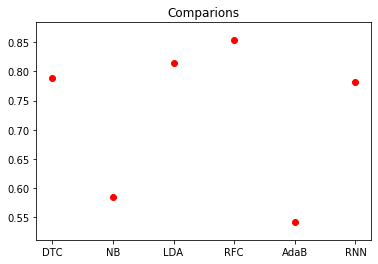

In [105]:
plt.scatter(np.arange(1,7), result, color='red')
plt.xticks(np.arange(1,7), name)
plt.title('Comparions')